In [3]:
import requests
import pandas as pd
import json

# Configura la URL de tu backend
BASE_URL = "http://localhost:3000/api/v1/sessions/all"
LIMIT = 1000  # Puedes ajustar este valor si tienes más de 1000 sesiones

# Descarga todas las páginas
all_sessions = []
page = 1
while True:
    params = {"page": page, "limit": LIMIT}
    response = requests.get(BASE_URL, params=params)
    data = response.json()
    all_sessions.extend(data['data'])
    print(f"Descargadas {len(data['data'])} sesiones de la página {page}")
    if page >= data['totalPages']:
        break
    page += 1

print(f"Total de sesiones descargadas: {len(all_sessions)}")

# Guarda los datos en un archivo para futuras cargas rápidas
with open("sessions_all.json", "w") as f:
    json.dump(all_sessions, f)

Descargadas 78 sesiones de la página 1
Total de sesiones descargadas: 78


In [4]:
df = pd.DataFrame(all_sessions)
df.head()

,_id,userId,date,startTime,endTime,totalDuration,totalRestTime,totalSets,exercises,statistics,createdAt,updatedAt,__v,notes
0,6874ac9acce77ea8580e6158,YEMGG1WruaXs0n17A49Nwu8sl9M2,2025-07-14T01:06:10.842Z,2025-07-14T01:06:28.213Z,2025-07-14T01:07:05.797Z,37,16,2,[{'id': '2e518f2c-1c67-467f-991d-4bd7e7a466e1'...,"{'setsByMuscleGroup': {'PECHO': 2}, 'totalComp...",2025-07-14T07:07:06.891Z,2025-07-14T07:07:06.891Z,0,NaN
1,687931e69144d73e51b0f643,YEMGG1WruaXs0n17A49Nwu8sl9M2,2025-07-17T17:18:31.985Z,2025-07-17T17:19:07.519Z,2025-07-17T17:24:52.797Z,345,1,1,[{'id': 'f546f651-f892-428c-a422-9fa1f7f6c111'...,"{'setsByMuscleGroup': {'PECHO': 1}, 'totalComp...",2025-07-17T17:24:54.156Z,2025-07-17T17:24:54.156Z,0,NaN
2,687934dd9144d73e51b0f645,YEMGG1WruaXs0n17A49Nwu8sl9M2,2025-07-17T17:32:39.733Z,2025-07-17T17:33:15.037Z,2025-07-17T17:37:32.148Z,257,11,4,[{'id': '0d68ffad-61c4-4b7c-ac7b-718bb2011e6d'...,"{'setsByMuscleGroup': {'ESPALDA': 2, 'PECHO': ...",2025-07-17T17:37:33.413Z,2025-07-17T17:37:33.413Z,0,NaN
3,687940c8b09cb64cd8a9811b,YEMGG1WruaXs0n17A49Nwu8sl9M2,2025-07-13T06:00:00.000Z,2025-07-17T18:27:58.014Z,2025-07-17T18:28:23.246Z,25,6,2,[{'id': 'c9f91355-40a2-4f43-b246-92de7a228420'...,"{'setsByMuscleGroup': {'ABDOMEN': 2}, 'totalCo...",2025-07-17T18:28:24.516Z,2025-07-17T18:28:24.516Z,0,NaN
4,687949a3b09cb64cd8a98125,YEMGG1WruaXs0n17A49Nwu8sl9M2,2025-07-30T06:00:00.000Z,2025-07-17T19:01:23.057Z,2025-07-17T19:06:09.882Z,286,129,3,[{'id': 'f33374d7-6f14-4319-8815-4fe5c69ec436'...,"{'setsByMuscleGroup': {'BICEP': 2, 'HOMBRO LAT...",2025-07-17T19:06:11.135Z,2025-07-17T19:06:11.135Z,0,NaN


In [5]:
## Eliminar columnas que no se van a usar : _id, userId, createdAt, updatedAt, notes, _v

df = df.drop(columns=['_id', 'userId', 'createdAt', 'updatedAt', 'notes', '__v'])

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
import pandas as pd
import numpy as np

def extract_exercise_features(exercises):
    total_sets = 0
    all_weights = []
    all_reps = []
    all_rest = []
    muscles_worked = set()

    for ex in exercises:
        muscles_worked.add(ex.get("muscleGroup", "").strip().upper())
        sets = ex.get("sets", [])
        for s in sets:
            if s.get("completed", True):  # solo incluir sets completados
                total_sets += 1
                all_weights.append(s.get("weight", 0))
                all_reps.append(s.get("reps", 0))
                all_rest.append(s.get("restTime", 0))

    return pd.Series({
        "total_sets": total_sets,
        "avg_weight": round(np.mean(all_weights), 2) if all_weights else 0,
        "std_weight": round(np.std(all_weights), 2) if all_weights else 0,
        "avg_reps": round(np.mean(all_reps), 2) if all_reps else 0,
        "std_reps": round(np.std(all_reps), 2) if all_reps else 0,
        "avg_restTime": round(np.mean(all_rest), 2) if all_rest else 0,
        "total_volume": round(sum([w * r for w, r in zip(all_weights, all_reps)]), 2),
        "muscle_groups_count": len(muscles_worked)
    })

# Aplica la función sobre tu DataFrame, donde df["exercises"] es una lista por sesión
df_features = df["exercises"].apply(extract_exercise_features)

# Une con el DataFrame original
df = pd.concat([df, df_features], axis=1)


In [8]:
df.tail()

,date,startTime,endTime,totalDuration,totalRestTime,totalSets,exercises,statistics,total_sets,avg_weight,std_weight,avg_reps,std_reps,avg_restTime,total_volume,muscle_groups_count
73,2025-07-19 15:00:00+00:00,2025-07-19T15:00:00.000Z,2025-07-19T16:45:06.000Z,6306,4592,20,[{'id': 'bc07a4a4-74a4-4a55-8155-8a631892cbce'...,"{'setsByMuscleGroup': {'CUADRICEP': 6, 'ISQUIO...",20.0,94.00,59.17,8.05,1.53,229.60,14295.0,6.0
74,2025-07-20 15:00:00+00:00,2025-07-20T15:00:00.000Z,2025-07-20T16:19:34.000Z,4774,3484,15,[{'id': '4dce3bea-2631-4fc7-99fd-a15688b4f65d'...,"{'setsByMuscleGroup': {'ESPALDA': 6, 'HOMBRO P...",15.0,51.33,27.22,9.27,1.29,232.27,6910.0,4.0
75,2025-07-21 15:00:00+00:00,2025-07-21T15:00:00.000Z,2025-07-21T16:17:56.000Z,4676,3198,14,[{'id': 'b1a8f562-2da9-40d5-8111-16b4c466d45d'...,"{'setsByMuscleGroup': {'PECHO': 6, 'TRICEP': 4...",14.0,41.96,27.19,10.43,1.18,228.43,6085.0,3.0
76,2025-07-22 15:00:00+00:00,2025-07-22T15:00:00.000Z,2025-07-22T16:32:03.000Z,5523,4008,17,[{'id': '06803125-ee00-4202-aa60-a0587d1ecd50'...,"{'setsByMuscleGroup': {'CUADRICEP': 6, 'ISQUIO...",17.0,102.50,74.21,8.88,1.28,235.76,15630.0,5.0
77,2025-07-23 15:00:00+00:00,2025-07-23T15:00:00.000Z,2025-07-23T16:30:10.000Z,5410,3715,17,[{'id': 'c4496b28-db5d-46fe-a3c5-050d53781359'...,"{'setsByMuscleGroup': {'PECHO': 4, 'ESPALDA': ...",17.0,45.59,26.84,10.24,1.00,218.53,7985.0,6.0


In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Creamos una lista donde guardaremos los resultados
slopes = []

# Iteramos sobre todos los ejercicios únicos encontrados en el dataset
for exercise_name in set(
    ex['name'] for session in df['exercises'] for ex in session
):
    # Lista para guardar fechas y pesos promedio por sesión
    dates = []
    avg_weights = []

    # Recorrer cada sesión
    for i, row in df.iterrows():
        for ex in row['exercises']:
            if ex['name'] == exercise_name:
                sets = ex.get('sets', [])
                weights = [s.get('weight', 0) for s in sets]
                if weights:
                    avg_weights.append(np.mean(weights))
                    dates.append(row['date'])

    # Si hay al menos 3 sesiones con ese ejercicio, calculamos tendencia
    if len(dates) >= 3:
        X = np.array([(d - min(dates)).days for d in dates]).reshape(-1, 1)
        y = np.array(avg_weights).reshape(-1, 1)
        model = LinearRegression().fit(X, y)
        slope = model.coef_[0][0]
    else:
        slope = np.nan  # No hay suficientes datos

    slopes.append({
        'exercise': exercise_name,
        'slope_weight': slope,
        'sessions_count': len(dates)
    })

# Convertimos a DataFrame para visualizar
df_slopes = pd.DataFrame(slopes)
df_slopes = df_slopes.sort_values('slope_weight', ascending=False)
df_slopes.head()


,exercise,slope_weight,sessions_count
11,HIP THRUST,0.674759,24
18,PRENSA DE CUADRICEPS,0.551587,12
22,PRESS MILITAR,0.345238,12
5,MAQUINA PARA ISQUIOTIBIALES ACOSTADO,0.345238,12
21,HACK MACHINE,0.333333,12


In [10]:
import pandas as pd

# Paso 1: Expandir setsByMuscleGroup en columnas numéricas
def expand_sets_by_muscle_group(stats):
    muscle_sets = stats.get('setsByMuscleGroup', {})
    return pd.Series({f'sets_{muscle.lower().replace(" ", "_")}': count for muscle, count in muscle_sets.items()})

df_muscles = df['statistics'].apply(expand_sets_by_muscle_group)
df_muscles = df_muscles.fillna(0)  # Rellena con 0 donde no se trabajó el músculo ese día

# Paso 2: Crear columna de músculo dominante (más sets ese día)
def get_dominant_muscle_group(stats):
    sets = stats.get('setsByMuscleGroup', {})
    if sets:
        return max(sets.items(), key=lambda x: x[1])[0]
    return None

df['dominant_muscle_group'] = df['statistics'].apply(get_dominant_muscle_group)

# (Opcional) One-hot encoding para modelos ML
df_dummies = pd.get_dummies(df['dominant_muscle_group'], prefix='dominancia')

# Combina todo con el DataFrame original
df = pd.concat([df, df_muscles, df_dummies], axis=1)


In [11]:
df.head()

,date,startTime,endTime,totalDuration,totalRestTime,totalSets,exercises,statistics,total_sets,avg_weight,...,sets_isquios,sets_gluteo,sets_pantorrilla,sets_abdominales,sets_antebrazos,dominancia_ABDOMEN,dominancia_BICEP,dominancia_CUADRICEP,dominancia_ESPALDA,dominancia_PECHO
0,2025-07-14 01:06:10.842000+00:00,2025-07-14T01:06:28.213Z,2025-07-14T01:07:05.797Z,37,16,2,[{'id': '2e518f2c-1c67-467f-991d-4bd7e7a466e1'...,"{'setsByMuscleGroup': {'PECHO': 2}, 'totalComp...",2.0,27.5,...,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True
1,2025-07-17 17:18:31.985000+00:00,2025-07-17T17:19:07.519Z,2025-07-17T17:24:52.797Z,345,1,1,[{'id': 'f546f651-f892-428c-a422-9fa1f7f6c111'...,"{'setsByMuscleGroup': {'PECHO': 1}, 'totalComp...",1.0,12.0,...,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True
2,2025-07-17 17:32:39.733000+00:00,2025-07-17T17:33:15.037Z,2025-07-17T17:37:32.148Z,257,11,4,[{'id': '0d68ffad-61c4-4b7c-ac7b-718bb2011e6d'...,"{'setsByMuscleGroup': {'ESPALDA': 2, 'PECHO': ...",4.0,29.5,...,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False
3,2025-07-13 06:00:00+00:00,2025-07-17T18:27:58.014Z,2025-07-17T18:28:23.246Z,25,6,2,[{'id': 'c9f91355-40a2-4f43-b246-92de7a228420'...,"{'setsByMuscleGroup': {'ABDOMEN': 2}, 'totalCo...",2.0,2.5,...,0.0,0.0,0.0,0.0,0.0,True,False,False,False,False
4,2025-07-30 06:00:00+00:00,2025-07-17T19:01:23.057Z,2025-07-17T19:06:09.882Z,286,129,3,[{'id': 'f33374d7-6f14-4319-8815-4fe5c69ec436'...,"{'setsByMuscleGroup': {'BICEP': 2, 'HOMBRO LAT...",3.0,21.5,...,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False


In [12]:
# --- Elimina columnas innecesarias o duplicadas ---
df = df.drop(columns=[
    "startTime", "endTime", "exercises", "statistics", "totalSets"
], errors='ignore')

# --- Feature 1: Índice de intensidad (volumen total / duración total) ---
df["intensity_index"] = df["total_volume"] / df["totalDuration"]

# --- Feature 2: Promedio de descanso por set ---
df["rest_per_set"] = df["totalRestTime"] / df["total_sets"]



In [13]:
df.head(10)
df.columns

Index(['date', 'totalDuration', 'totalRestTime', 'total_sets', 'avg_weight',
       'std_weight', 'avg_reps', 'std_reps', 'avg_restTime', 'total_volume',
       'muscle_groups_count', 'dominant_muscle_group', 'sets_pecho',
       'sets_espalda', 'sets_abdomen', 'sets_bicep', 'sets_hombro_lateral',
       'sets_hombro', 'sets_tricep', 'sets_hombro_posterior', 'sets_cuadricep',
       'sets_isquios', 'sets_gluteo', 'sets_pantorrilla', 'sets_abdominales',
       'sets_antebrazos', 'dominancia_ABDOMEN', 'dominancia_BICEP',
       'dominancia_CUADRICEP', 'dominancia_ESPALDA', 'dominancia_PECHO',
       'intensity_index', 'rest_per_set'],
      dtype='object')

In [14]:
# Definir los pesos musculares
MUSCLE_WEIGHTS = {
    'sets_cuadricep': 1.0,
    'sets_isquios': 1.0,
    'sets_gluteo': 1.0,
    'sets_espalda': 0.8,
    'sets_pecho': 0.8,
    'sets_hombros': 0.6,
    'sets_hombro': 0.6,
    'sets_hombro_lateral': 0.6,
    'sets_hombro_posterior': 0.6,
    'sets_bíceps': 0.4,
    'sets_biceps': 0.4,
    'sets_tricep': 0.4,
    'sets_abdomen': 0.3,
    'sets_abdominales': 0.3,
    'sets_pantorrilla': 0.3,
    'sets_antebrazos': 0.2,
}

# Función para calcular el rendimiento ponderado
def compute_adjusted_performance(row):
    total = 0.0
    for col, weight in MUSCLE_WEIGHTS.items():
        total += row.get(col, 0) * weight
    return total * row['avg_weight'] * row['avg_reps']

# Aplicar la función
df['adjusted_performance'] = df.apply(compute_adjusted_performance, axis=1)
print(df['adjusted_performance'])

0       484.00000
1       297.60000
2      1132.80000
3        30.00000
4       249.35700
         ...     
73    10669.47000
74     3140.47206
75     3851.25664
76    12287.70000
77     4761.78432
Name: adjusted_performance, Length: 78, dtype: float64


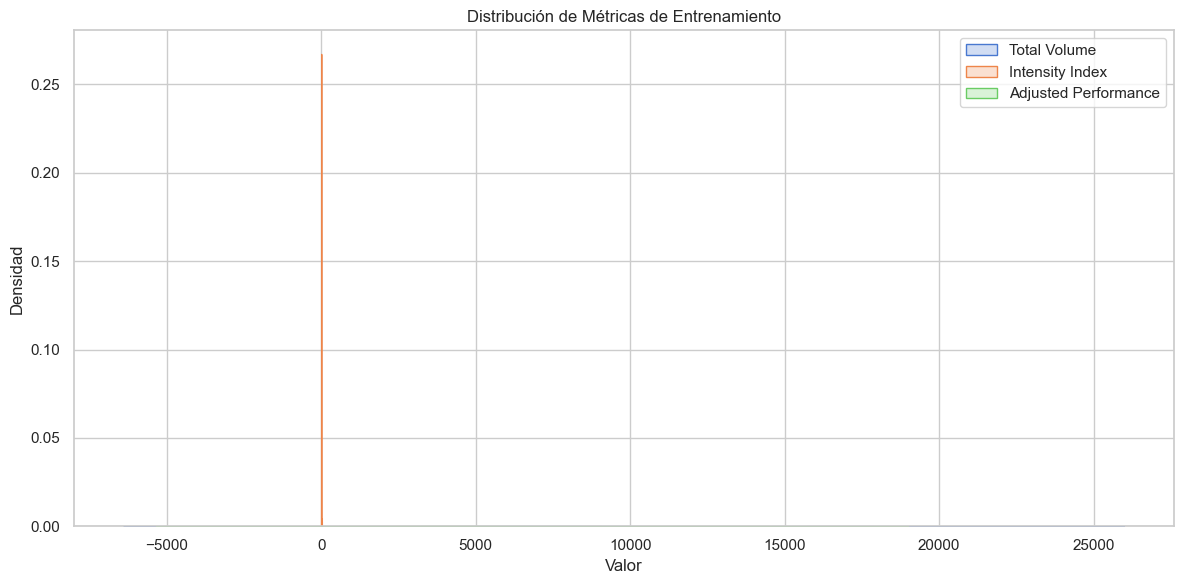

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general
sns.set(style="whitegrid", palette="muted")

# Crear figura
plt.figure(figsize=(12, 6))
sns.kdeplot(df['total_volume'], label='Total Volume', fill=True)
sns.kdeplot(df['intensity_index'], label='Intensity Index', fill=True)
sns.kdeplot(df['adjusted_performance'], label='Adjusted Performance', fill=True)
plt.title('Distribución de Métricas de Entrenamiento')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.legend()
plt.tight_layout()
plt.show()


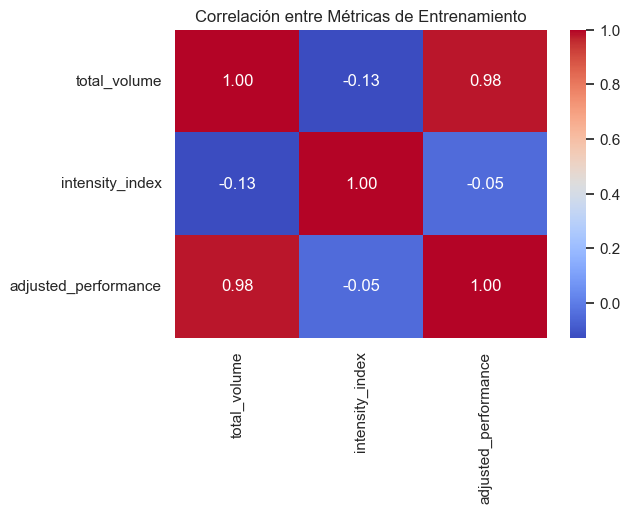

In [16]:
import numpy as np

# Seleccionar las columnas relevantes
metrics_df = df[['total_volume', 'intensity_index', 'adjusted_performance']]

# Calcular matriz de correlación
corr = metrics_df.corr()

# Mapa de calor
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlación entre Métricas de Entrenamiento')
plt.show()


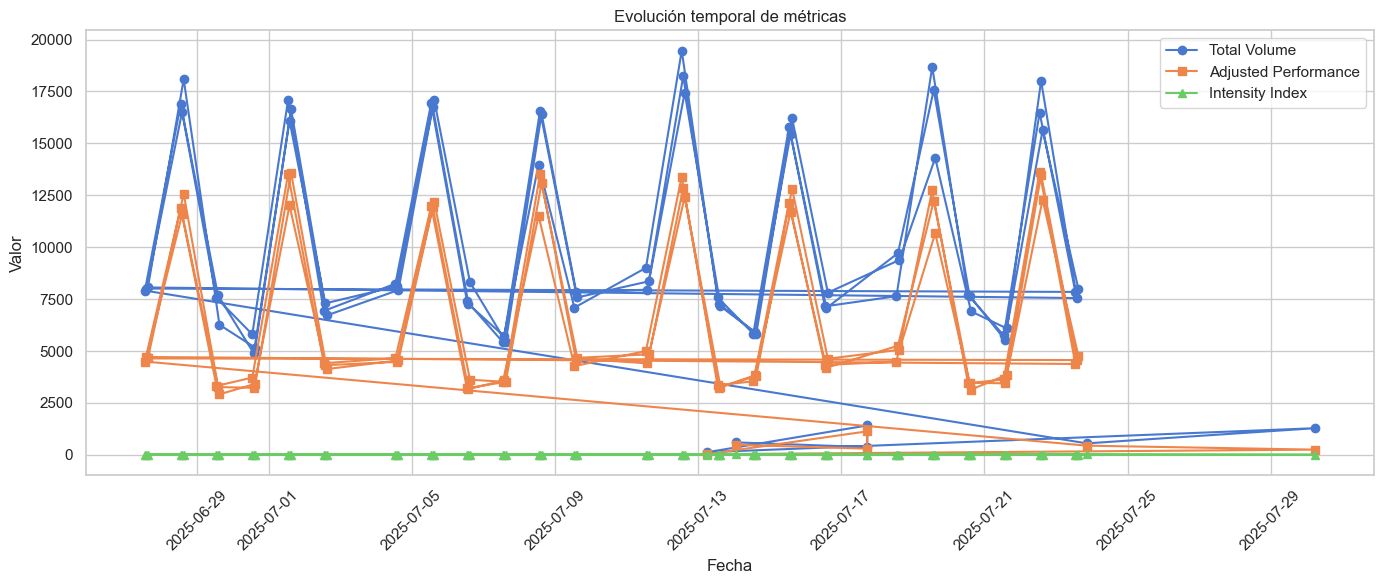

In [17]:
# Visualización en línea temporal
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['total_volume'], label='Total Volume', marker='o')
plt.plot(df['date'], df['adjusted_performance'], label='Adjusted Performance', marker='s')
plt.plot(df['date'], df['intensity_index'], label='Intensity Index', marker='^')
plt.title('Evolución temporal de métricas')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
# Calcular diferencias relativas
df['diff_adjusted_vs_volume'] = np.abs(df['adjusted_performance'] - df['total_volume']) / (df['total_volume'] + 1e-5)

# Mostrar las sesiones con más diferencia
df[['date', 'total_volume', 'adjusted_performance', 'diff_adjusted_vs_volume']].sort_values(
    'diff_adjusted_vs_volume', ascending=False).head(10)


,date,total_volume,adjusted_performance,diff_adjusted_vs_volume
4,2025-07-30 06:00:00+00:00,1284.0,249.35700,0.805797
3,2025-07-13 06:00:00+00:00,125.0,30.00000,0.760000
32,2025-06-29 14:00:00+00:00,7685.0,3264.67614,0.575189
14,2025-07-06 13:00:00+00:00,7400.0,3199.98294,0.567570
62,2025-07-06 15:00:00+00:00,8310.0,3617.65800,0.564662
38,2025-07-06 14:00:00+00:00,7252.5,3169.32000,0.563003
8,2025-06-29 13:00:00+00:00,7560.0,3317.37120,0.561194
20,2025-07-13 13:00:00+00:00,7590.0,3354.81300,0.557996
44,2025-07-13 14:00:00+00:00,7270.0,3234.00000,0.555158
26,2025-07-20 13:00:00+00:00,7695.0,3444.76440,0.552337


ESTOS SON ISO PERO CON EL DATASET ENTERO, YA NO LOS USAREMOS SINO QUE UTILZIAREMOS LA NUEVA METRICA

🔴 Sesiones anómalas detectadas:


,date,totalDuration,avg_weight,total_volume,anomaly
0,2025-07-14 01:06:10.842000+00:00,37,27.50,600.0,-1
1,2025-07-17 17:18:31.985000+00:00,345,12.00,372.0,-1
2,2025-07-17 17:32:39.733000+00:00,257,29.50,1416.0,-1
3,2025-07-13 06:00:00+00:00,25,2.50,125.0,-1
4,2025-07-30 06:00:00+00:00,286,21.50,1284.0,-1
5,2025-07-23 20:40:08.611000+00:00,26,23.00,552.0,-1
56,2025-06-29 15:00:00+00:00,4783,47.67,6262.5,-1
73,2025-07-19 15:00:00+00:00,6306,94.00,14295.0,-1


TOTAL DE SESIONES ANÓMALAS:  8


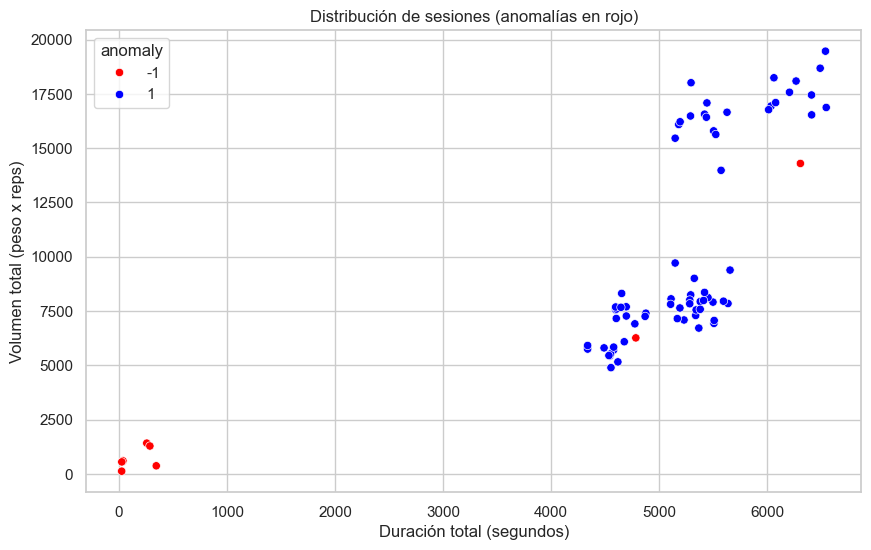

In [22]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Seleccionamos solo columnas numéricas relevantes
# -------------------------------
features = [
    'totalDuration', 'totalRestTime', 'total_sets', 'avg_weight', 'std_weight',
    'avg_reps', 'std_reps', 'avg_restTime', 'total_volume', 'intensity_index',
    'rest_per_set'
]

# Incluye también las columnas de sets por grupo muscular si quieres
muscle_columns = [col for col in df.columns if col.startswith("sets_")]
features.extend(muscle_columns)

# -------------------------------
# 2. Escalado (opcional, pero recomendado)
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# -------------------------------
# 3. Entrenamiento de Isolation Forest
# -------------------------------
model = IsolationForest(contamination=0.1, random_state=42)
df["anomaly"] = model.fit_predict(X_scaled)

# -------------------------------
# 4. Visualización
# -------------------------------

# Visualizamos las sesiones anómalas
outliers = df[df["anomaly"] == -1]
print("🔴 Sesiones anómalas detectadas:")
display(outliers[["date", "totalDuration", "avg_weight", "total_volume", "anomaly"]])
print("TOTAL DE SESIONES ANÓMALAS: ", len(outliers))

# Opcional: gráfico para ver la distribución
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="totalDuration", y="total_volume",
    data=df, hue="anomaly", palette={1: "blue", -1: "red"}
)
plt.title("Distribución de sesiones (anomalías en rojo)")
plt.xlabel("Duración total (segundos)")
plt.ylabel("Volumen total (peso x reps)")
plt.show()


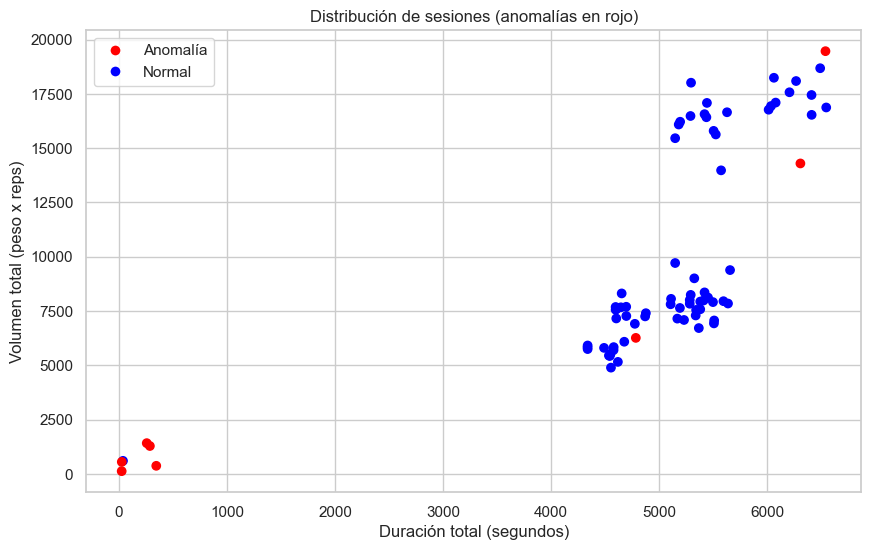

🔴 Sesiones anómalas detectadas:


,date,totalDuration,avg_weight,total_volume,anomaly
1,2025-07-17 17:18:31.985000+00:00,345,12.00,372.0,-1
2,2025-07-17 17:32:39.733000+00:00,257,29.50,1416.0,-1
3,2025-07-13 06:00:00+00:00,25,2.50,125.0,-1
4,2025-07-30 06:00:00+00:00,286,21.50,1284.0,-1
5,2025-07-23 20:40:08.611000+00:00,26,23.00,552.0,-1
19,2025-07-12 13:00:00+00:00,6538,91.38,19465.0,-1
56,2025-06-29 15:00:00+00:00,4783,47.67,6262.5,-1
73,2025-07-19 15:00:00+00:00,6306,94.00,14295.0,-1


total de sesiones anómalas:  8


In [86]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define las columnas que quieres usar como features
features = [
    'totalDuration', 'total_volume', 'avg_weight',
    'sets_pecho', 'sets_espalda', 'sets_abdomen', 'sets_hombro', 'sets_tricep', 'sets_bicep', 'sets_hombro_posterior', 'sets_hombro_lateral', 'sets_cuadricep', 'sets_isquios', 'sets_gluteo', 'sets_pantorrilla', 'sets_abdominales', 'sets_antebrazos'
]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Modelo
model = IsolationForest(contamination=0.1, random_state=42)
df['anomaly'] = model.fit_predict(X_scaled)

# Visualización 2D usando duración vs volumen
plt.figure(figsize=(10, 6))
colors = df['anomaly'].map({1: 'blue', -1: 'red'})
plt.scatter(df['totalDuration'], df['total_volume'], c=colors)
plt.xlabel("Duración total (segundos)")
plt.ylabel("Volumen total (peso x reps)")
plt.title("Distribución de sesiones (anomalías en rojo)")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Anomalía', markerfacecolor='red', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='blue', markersize=8)
])
plt.grid(True)
plt.show()
outliers = df[df["anomaly"] == -1]
print("🔴 Sesiones anómalas detectadas:")
display(outliers[["date", "totalDuration", "avg_weight", "total_volume", "anomaly"]])
print("total de sesiones anómalas: ", len(outliers))


In [87]:
# Filtra las columnas que comienzan con 'sets_'
set_columns = [col for col in df.columns if col.startswith('sets_')]
print("Columnas 'sets_':")
print(set_columns)


Columnas 'sets_':
['sets_pecho', 'sets_espalda', 'sets_abdomen', 'sets_bicep', 'sets_hombro_lateral', 'sets_hombro', 'sets_tricep', 'sets_hombro_posterior', 'sets_cuadricep', 'sets_isquios', 'sets_gluteo', 'sets_pantorrilla', 'sets_abdominales', 'sets_antebrazos']


In [88]:
# Crear columna vacía con valor por defecto
df['anomaly_reason'] = 'No explicada'

# Explicación 1: Sesión muy pesada de pierna → volumen alto y dominancia de pierna
cond_pierna_pesada = (df['anomaly'] == -1) & (
    (df['dominancia_CUADRICEP'] | df.get('dominancia_GLÚTEO', False)) &
    (df['total_volume'] > df['total_volume'].quantile(0.90))
)
df.loc[cond_pierna_pesada, 'anomaly_reason'] = 'Día de pierna pesado'

# Explicación 2: Sesión ligera de pecho u hombro → volumen muy bajo
cond_pecho_ligero = (df['anomaly'] == -1) & (
    (df['dominancia_PECHO'] | df.get('dominancia_HOMBRO', False)) &
    (df['total_volume'] < df['total_volume'].quantile(0.10))
)
df.loc[cond_pecho_ligero, 'anomaly_reason'] = 'Día ligero de torso'

# Explicación 3: Sesión muy corta en tiempo y volumen → probable sesión incompleta
cond_sesion_corta = (df['anomaly'] == -1) & (
    (df['totalDuration'] < 600) & (df['total_volume'] < 1000)
)
df.loc[cond_sesion_corta, 'anomaly_reason'] = 'Sesión muy corta'

# Explicación 4: Volumen alto sin dominancia clara → posible sobreentrenamiento o error
cond_volumen_alto_raro = (df['anomaly'] == -1) & (
    (df['total_volume'] > df['total_volume'].quantile(0.95)) &
    ~(df.filter(like="dominancia_").any(axis=1))
)
df.loc[cond_volumen_alto_raro, 'anomaly_reason'] = 'Volumen alto sin grupo dominante'


In [18]:
# Solo anomalías con explicación
df_explicadas = df[df['anomaly_reason'] != 'No explicada']

# Solo anomalías sin explicación
df_no_explicadas = df[df['anomaly_reason'] == 'No explicada']

# Vista rápida
print("✔️ Anomalías explicadas:", len(df_explicadas))
print("❌ Anomalías sin explicación:", len(df_no_explicadas))

# Mostrar ejemplos
df_explicadas[['date', 'totalDuration', 'total_volume', 'anomaly_reason']].head()


✔️ Anomalías explicadas: 3
❌ Anomalías sin explicación: 75


,date,totalDuration,total_volume,anomaly_reason
1,2025-07-17 17:18:31.985000+00:00,345,372.0,Sesión muy corta
3,2025-07-13 06:00:00+00:00,25,125.0,Sesión muy corta
19,2025-07-12 13:00:00+00:00,6538,19465.0,Día de pierna pesado


02:29:10 - cmdstanpy - INFO - Chain [1] start processing
02:29:10 - cmdstanpy - INFO - Chain [1] done processing


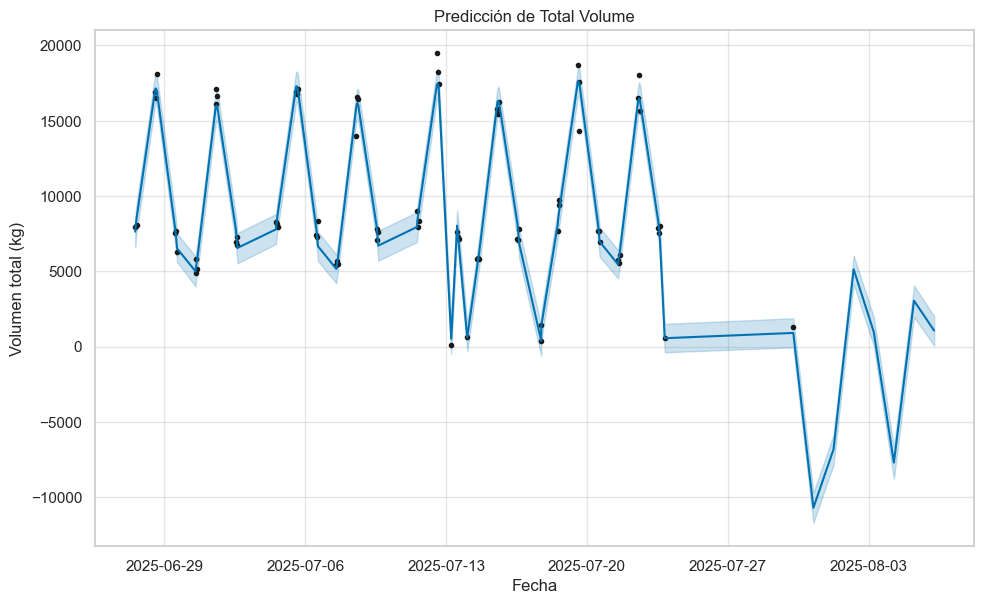

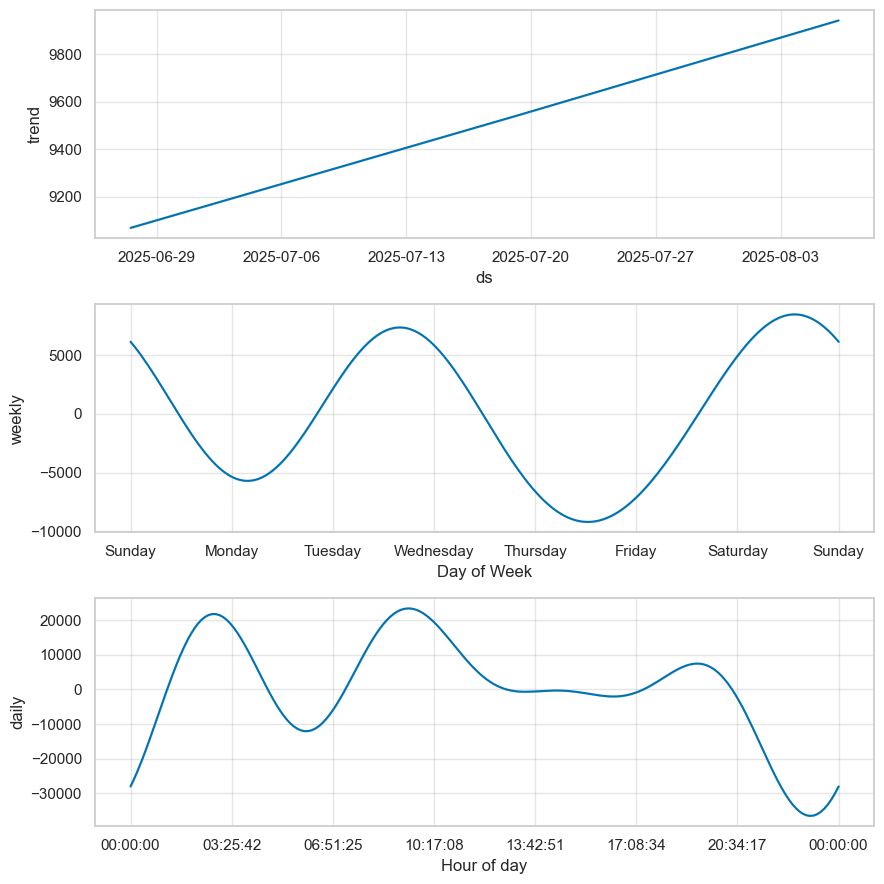

🔍 Anomalías detectadas por Prophet:

                    ds        y          yhat    yhat_lower    yhat_upper
16 2025-07-08 13:00:00  13977.5  16021.051987  15037.480965  16912.712125
23 2025-07-16 13:00:00   7150.0   8145.275544   7158.285122   9121.085182
73 2025-07-19 15:00:00  14295.0  17405.774845  16480.935778  18385.698708


In [89]:
# ---------------------------------------------
# 1. Imports necesarios
# ---------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# ---------------------------------------------
# 2. Preparar el DataFrame para Prophet
# ---------------------------------------------
# Asegurarse que la columna 'date' está como datetime
df['date'] = pd.to_datetime(df['date'])

# 1. Crear el DataFrame con Prophet
df_prophet = df[['date', 'total_volume']].rename(columns={'date': 'ds', 'total_volume': 'y'})

# 2. Eliminar zona horaria si existe (muy importante para Prophet)
df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)


# ---------------------------------------------
# 3. Entrenar el modelo Prophet
# ---------------------------------------------
model = Prophet()
model.fit(df_prophet)

# ---------------------------------------------
# 4. Generar fechas futuras y hacer predicciones
# ---------------------------------------------
future = model.make_future_dataframe(periods=7)  # predice 7 días a futuro (puedes ajustar)
forecast = model.predict(future)

# ---------------------------------------------
# 5. Visualizar la predicción
# ---------------------------------------------
fig1 = model.plot(forecast)
plt.title("Predicción de Total Volume")
plt.xlabel("Fecha")
plt.ylabel("Volumen total (kg)")
plt.show()

# Componentes estacionales
fig2 = model.plot_components(forecast)
plt.show()

# ---------------------------------------------
# 6. Detectar anomalías comparando predicción real con intervalo inferior
# ---------------------------------------------
# Unimos la predicción con los datos reales
merged = pd.merge(df_prophet, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# Creamos la columna de anomalía: True si el valor real cae por debajo del intervalo inferior
merged['anomaly'] = merged['y'] < merged['yhat_lower']

# ---------------------------------------------
# 7. Mostrar anomalías detectadas
# ---------------------------------------------
anomalies = merged[merged['anomaly']]

print("🔍 Anomalías detectadas por Prophet:\n")
print(anomalies[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']])


ACA TERMINA E INICIA LA NUEVA METRICA

In [ ]:
import os
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd
# Preparamos features
feature_cols = ['adjusted_performance', 'avg_weight', 'avg_reps', 
                'std_weight', 'rest_per_set', 'total_sets', 'totalDuration']
df_model = df[feature_cols].copy().dropna()

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

# Entrenamiento
model = IsolationForest(contamination=0.1, random_state=42)
df['anomaly'] = model.fit_predict(X_scaled)
df['anomaly_label'] = df['anomaly'].map({1: 'Normal', -1: 'Anomalía'})
df['risk_score'] = model.decision_function(X_scaled) * -1  # cuanto menor, más anómalo


os.makedirs("models", exist_ok=True)

# Guardar modelo y scaler por separado
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(model, 'models/modelo_isolation.pkl')

print("✅ Modelo y scaler guardados correctamente.")

✅ Modelo y scaler guardados correctamente.


In [23]:
# Visualización de puntos anómalos vs normales
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_anom,
    x='date',
    y='adjusted_performance',
    hue='anomaly_label',
    palette={'Normal': 'blue', 'Anomalía': 'red'}
)
plt.title('Anomalías en Adjusted Performance')
plt.xlabel('Fecha')
plt.ylabel('Performance Ajustado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'df_anom' is not defined

<Figure size 1200x600 with 0 Axes>

In [24]:
# Mostrar las sesiones anómalas
df_anomalias = df_anom[df_anom['anomaly'] == -1]
display(df_anomalias)
print("total de sesiones anómalas: ", len(df_anomalias))


NameError: name 'df_anom' is not defined

In [25]:
def clasificar_anomalia(row):
    if row['total_sets'] <= 2 and row['adjusted_performance'] < 1000:
        return 'Sesión muy corta'
    elif row['adjusted_performance'] > 13000 and row['avg_reps'] < 6:
        return 'Carga excesiva'
    elif row['rest_per_set'] > 180:
        return 'Descanso excesivo'
    elif row['std_weight'] > 25:
        return 'Pesos inestables'
    else:
        return 'Desempeño irregular'


In [26]:
df['anomaly_reason'] = None
df.loc[df['anomaly'] == -1, 'anomaly_reason'] = df[df['anomaly'] == -1].apply(clasificar_anomalia, axis=1)


C:\Users\Toled\AppData\Local\Temp\ipykernel_9520\269070600.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='anomaly_reason', data=anomalias, order=anomalias['anomaly_reason'].value_counts().index, palette='Reds_r')


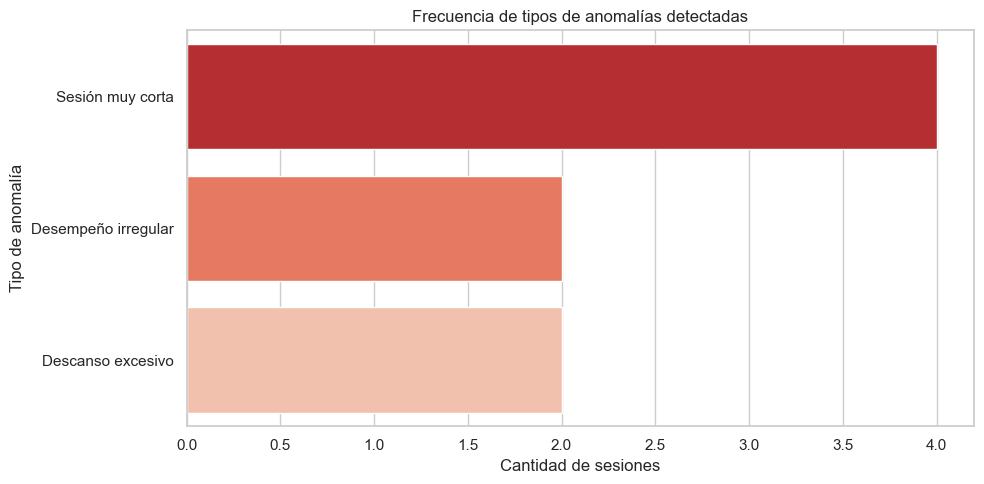

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo anomalias con causa identificada
anomalias = df[df['anomaly'] == -1]

plt.figure(figsize=(10, 5))
sns.countplot(y='anomaly_reason', data=anomalias, order=anomalias['anomaly_reason'].value_counts().index, palette='Reds_r')
plt.title('Frecuencia de tipos de anomalías detectadas')
plt.xlabel('Cantidad de sesiones')
plt.ylabel('Tipo de anomalía')
plt.tight_layout()
plt.show()


C:\Users\Toled\AppData\Local\Temp\ipykernel_19208\3533924043.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='anomaly_reason', y='risk_score', data=anomalias, palette='coolwarm')


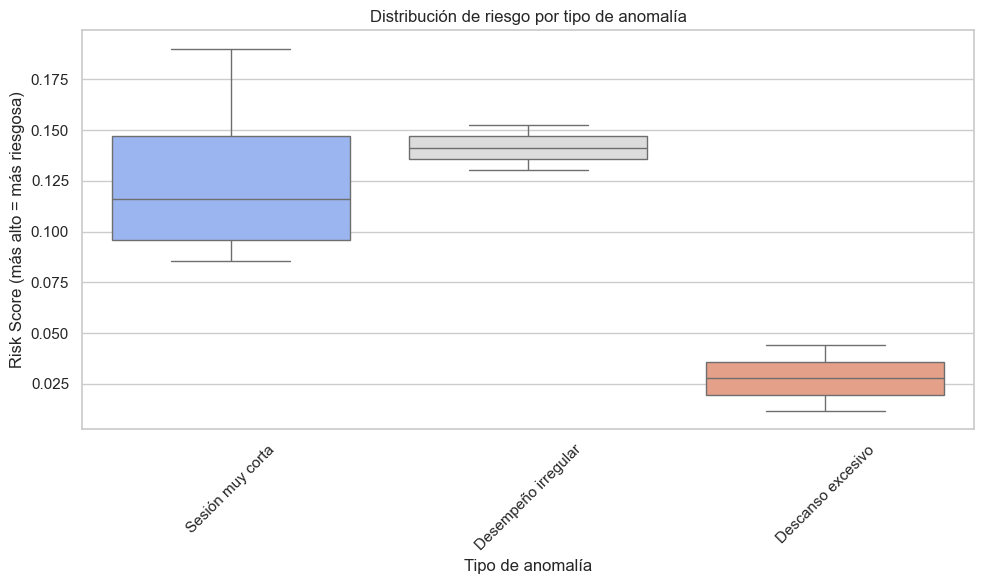

In [97]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='anomaly_reason', y='risk_score', data=anomalias, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Distribución de riesgo por tipo de anomalía')
plt.ylabel('Risk Score (más alto = más riesgosa)')
plt.xlabel('Tipo de anomalía')
plt.tight_layout()
plt.show()


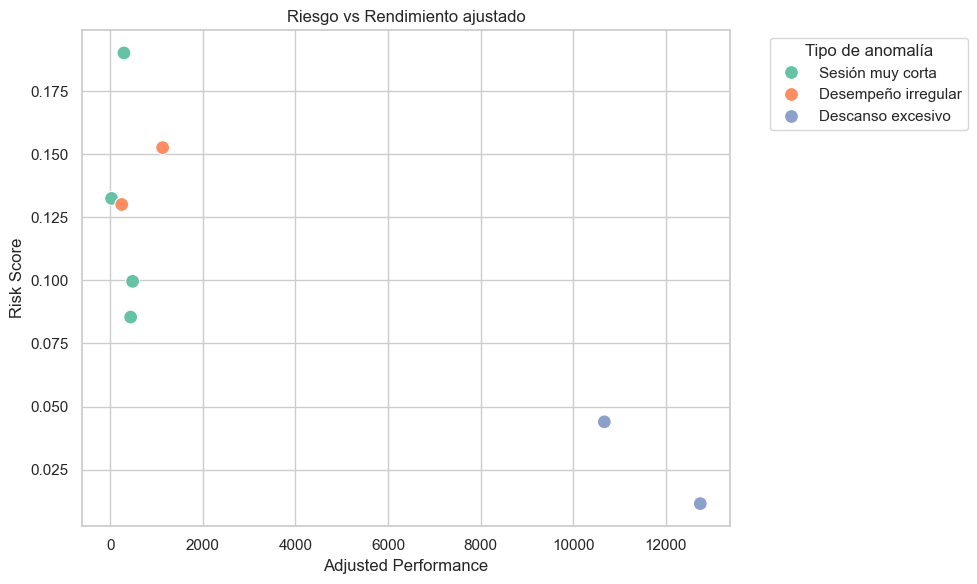

In [98]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=anomalias, x='adjusted_performance', y='risk_score', hue='anomaly_reason', palette='Set2', s=100)
plt.title('Riesgo vs Rendimiento ajustado')
plt.xlabel('Adjusted Performance')
plt.ylabel('Risk Score')
plt.legend(title='Tipo de anomalía', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [77]:
df.groupby('dominant_muscle_group')['adjusted_performance'].describe()


,count,mean,std,min,25%,50%,75%,max
dominant_muscle_group,,,,,,,,
ABDOMEN,1.0,30.000000,NaN,30.000,30.000000,30.00000,30.00000,30.00000
BICEP,1.0,249.357000,NaN,249.357,249.357000,249.35700,249.35700,249.35700
CUADRICEP,24.0,12490.505906,786.837061,10669.470,11961.456525,12356.34525,13162.12830,13620.38490
ESPALDA,13.0,3117.472971,620.717309,1132.800,3169.320000,3264.67614,3354.81300,3617.65800
PECHO,39.0,3951.884568,1155.989800,297.600,3607.893520,4329.42468,4629.82794,5250.51072


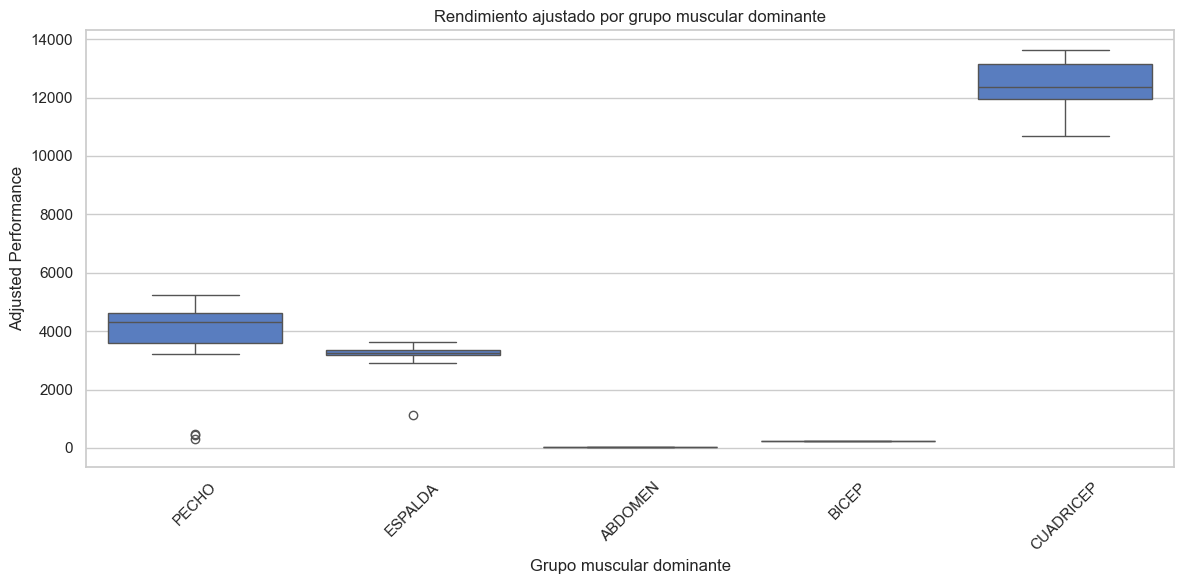

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='dominant_muscle_group', y='adjusted_performance')
plt.xticks(rotation=45)
plt.title('Rendimiento ajustado por grupo muscular dominante')
plt.ylabel('Adjusted Performance')
plt.xlabel('Grupo muscular dominante')
plt.tight_layout()
plt.show()


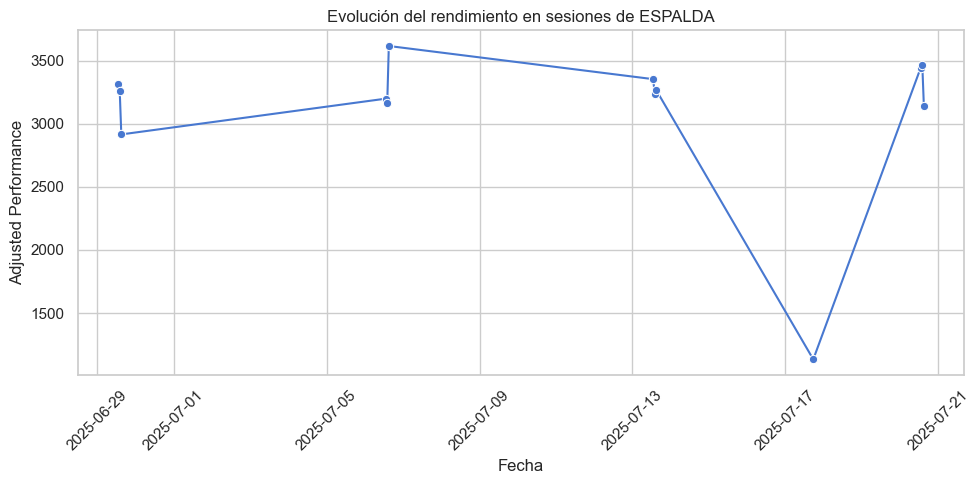

In [90]:
df_espalda = df[df['dominant_muscle_group'] == 'ESPALDA']
df_espalda = df_espalda.sort_values('date')

plt.figure(figsize=(10,5))
sns.lineplot(data=df_espalda, x='date', y='adjusted_performance', marker='o')
plt.title('Evolución del rendimiento en sesiones de ESPALDA')
plt.ylabel('Adjusted Performance')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


02:23:59 - cmdstanpy - INFO - Chain [1] start processing
02:24:00 - cmdstanpy - INFO - Chain [1] done processing


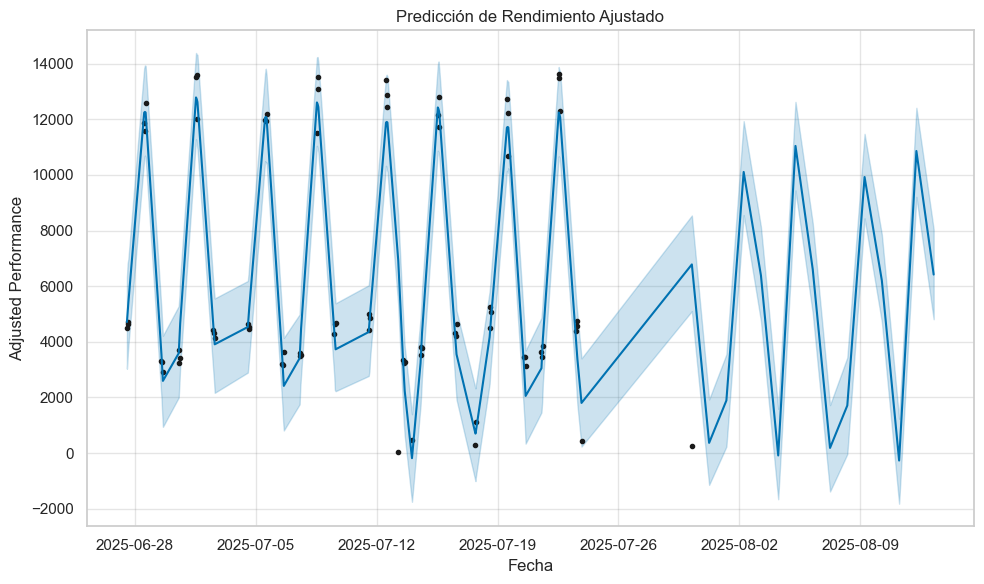

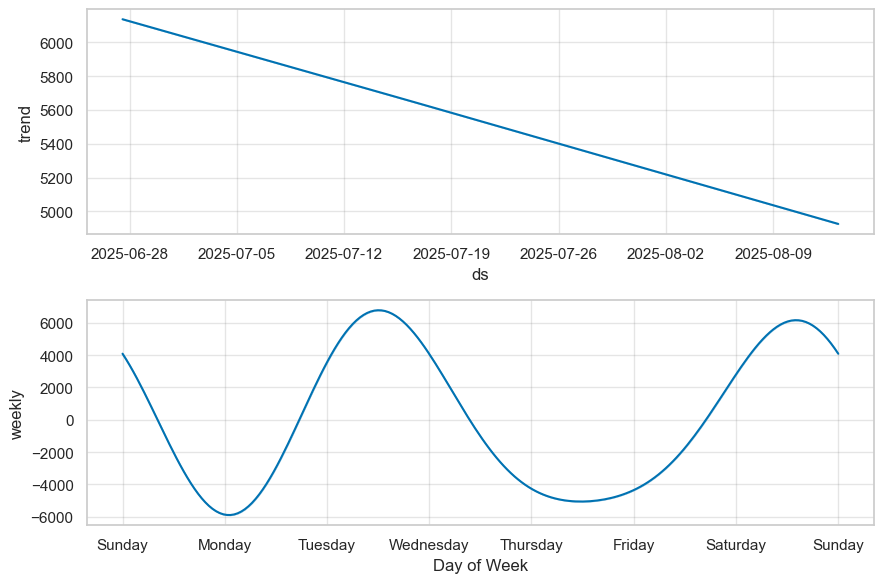

In [83]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Asegúrate de tener tu DataFrame 'df' con las columnas: 'date' y 'adjusted_performance'
df_prophet = df[['date', 'adjusted_performance']].copy()
df_prophet.columns = ['ds', 'y']
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)

# Inicializa y ajusta el modelo
model = Prophet(daily_seasonality=False, weekly_seasonality=True)
model.fit(df_prophet)

# Genera predicciones para los próximos 7 días
future = model.make_future_dataframe(periods=14, freq='D')
forecast = model.predict(future)

# Gráfico de la predicción
fig1 = model.plot(forecast)
plt.title("Predicción de Rendimiento Ajustado")
plt.xlabel("Fecha")
plt.ylabel("Adjusted Performance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico de componentes de la serie
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()
